In [ ]:
#package imports:

import os 
import torch
import pandas as pd
from torch_geometric.data import Data

In [1]:
#run this on collab servers
from colabcode import ColabCode
# run colabcode with by default options.
ColabCode()

FileNotFoundError: [WinError 2] Le fichier spécifié est introuvable

In [2]:
#class defs

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        """
        Args:
            patience: Number of epochs with no improvement after which training stops.
            min_delta: Minimum change in the monitored metric to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def check(self, current_loss):
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0  # Reset counter if improvement occurs
        else:
            self.counter += 1
        return self.counter >= self.patience

In [3]:
#function defs
def length_tensor(sample):
    """
        Function to create a tensor of lengths of the fibers
    """

    lengths = torch.empty(0)
    core_points = sample['flow_core_points']
    labels = sample['labels'][sample['labels'] != -1]

    # Get the unique labels
    unique_labels = torch.unique(labels)  

    for label in unique_labels:
        # Get the points with the unique label
        core_points_label = core_points[labels == label]

        unique_core_points = torch.unique(core_points_label)
        num_unique_flow_core_points = len(unique_core_points)

        length = sample['step_size'] * (num_unique_flow_core_points - 1)

        lengths = torch.cat((lengths, torch.tensor([length])))

    return lengths

def filter_noise(sim_data):
    points = sim_data['points']
    labels = sim_data['labels']

    mask = labels.squeeze() != -1

    filtered_points = points[mask]
    filtered_labels = labels[mask]

    sim_data['points'] = filtered_points
    sim_data['labels'] = filtered_labels
    return sim_data


def SPP_dataset_build(sim_dict):
    #extract individual fiber graphs
    #for every i fiber in sim_nb -> graph_nb_i

    
    # Initialize the output datasets for each label
    SPP_dataset = {}

    # Iterate through the simulations in sim_dict
    for sim_name, sim_data in sim_dict.items():
        points = sim_data['points']
        labels = sim_data['labels'].squeeze()  # Remove extra dimension if present
        lengths = sim_data['lengths']
        
        # Get unique labels
        unique_labels = torch.unique(labels).tolist()
        
        for n, label in enumerate(unique_labels):
            # Filter points and labels for the current graph
            label_mask = (labels == label)
            fiber_points = points[label_mask]
            fiber_length = lengths[n]

            # Create a PyTorch Geometric Data object for the label -> change the label to fiber length 
            SPP_data = Data(x=fiber_points, y=fiber_length)

            SPP_dataset[f'{sim_name}_{int(label)}'] = SPP_data

            f'{sim_name}_{int(label)}'

    return SPP_dataset



In [4]:
# setup directory of imported data

directory = r'C:\Users\Arthur Champain\Downloads\Arthur-20241118T122838Z-001\Arthur'

filelist = [os.path.join(directory, f) for f in os.listdir(directory)]

C:\Users\Arthur Champain\AppData\Local\Temp\ipykernel_17584\2553949103.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_visu_data = torch.load(test_path)


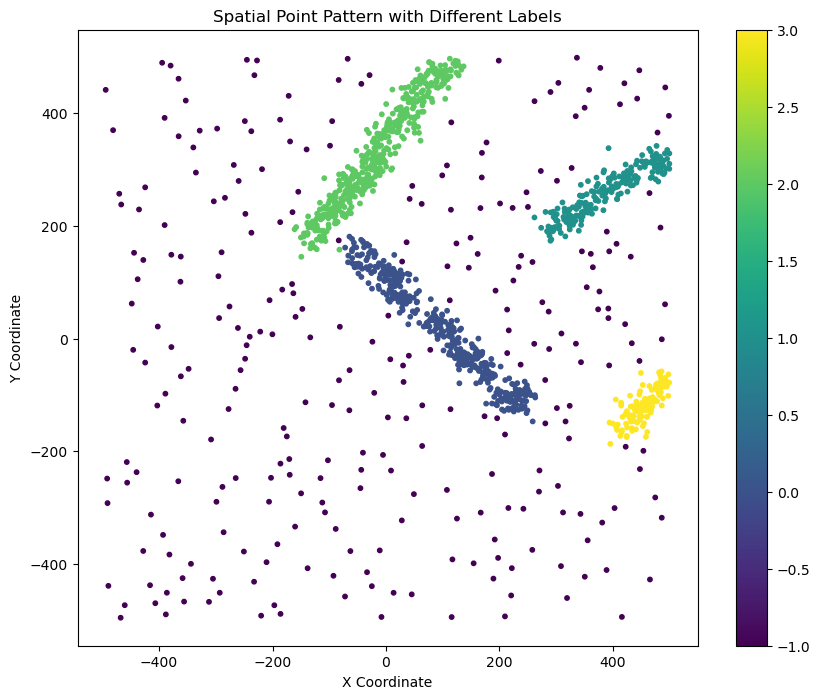

C:\Users\Arthur Champain\AppData\Local\Temp\ipykernel_17584\2553949103.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_visu_data_clean = filter_noise(torch.load(te

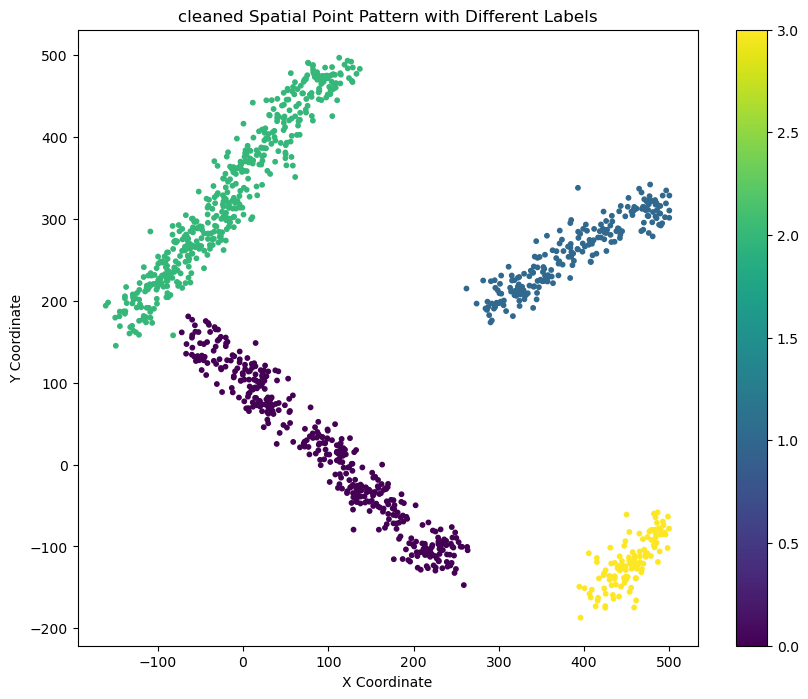

In [5]:
#visualize SPP

import torch
import matplotlib.pyplot as plt
import numpy as np

# Load your data
test_path = filelist[20]  # first file is the metadata, file 1 = sim_0
test_visu_data = torch.load(test_path)

# Extract points and labels
points = test_visu_data['points'].numpy()  # convert to NumPy array for easier plotting
labels = test_visu_data['labels'].numpy().flatten()  # flatten labels to 1D for color mapping

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='viridis', s=10)
plt.colorbar(scatter)  # Show color bar to indicate labels
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Spatial Point Pattern with Different Labels')
plt.show()

test_visu_data_clean = filter_noise(torch.load(test_path))

# Extract points and labels
points = test_visu_data_clean['points'].numpy()  # convert to NumPy array for easier plotting
labels = test_visu_data_clean['labels'].numpy().flatten()  # flatten labels to 1D for color mapping

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='viridis', s=10)
plt.colorbar(scatter)  # Show color bar to indicate labels
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('cleaned Spatial Point Pattern with Different Labels')
plt.show()



In [6]:
# import the simulated data

sim_dict = {}

for n, file_path in enumerate(filelist):
    file_extension = os.path.splitext(file_path)[1].lower()
    file_name = os.path.splitext(os.path.basename(file_path))[0]
    
    if n in range(100):
        #for overheating purposes limit to 50 file imports

        if file_extension == '.pt':
            #import and filter noise
            sim_dict[file_name] = filter_noise(torch.load(file_path))

            #update the lengths of the fibers
            updated_lengths = length_tensor(sim_dict[file_name])
            sim_dict[file_name]['lengths'] = updated_lengths
            
        elif file_extension == '.csv':
            descriptor = pd.read_csv(file_path, header=0)
            
        else:
            print(f'Unknown file format: {file_name}.{file_extension}')

SPP_dataset = SPP_dataset_build(sim_dict)


C:\Users\Arthur Champain\AppData\Local\Temp\ipykernel_17584\4248998088.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sim_dict[file_name] = filter_noise(torch.load(fil

In [7]:
#individual spp test
# Example: Access the dataset for a specific graph
graph_key = 'sim_0_0'  # Replace with the desired key
graph_data = SPP_dataset[graph_key]

# Extract the points data
points_data = graph_data.x
print(points_data)

tensor([[-484.3991,  283.5650],
        [-462.9771,  296.1790],
        [-458.5685,  303.1981],
        [-450.5583,  320.6542],
        [-463.1864,  298.7051],
        [-463.0354,  299.4094],
        [-474.5646,  279.4828],
        [-470.6281,  281.3760],
        [-466.3105,  274.9746],
        [-479.1341,  282.5919],
        [-468.5033,  285.3144],
        [-473.0438,  303.0016],
        [-469.8043,  289.3516],
        [-466.0860,  293.9255],
        [-447.6135,  329.2720],
        [-463.1879,  301.0670],
        [-483.1108,  295.3173],
        [-468.0423,  308.1521],
        [-457.1472,  295.8488],
        [-486.6882,  249.0737],
        [-474.2388,  287.0768],
        [-458.1270,  291.0804],
        [-455.4367,  308.4855],
        [-472.8442,  297.9847],
        [-460.2353,  310.1223],
        [-458.4916,  305.9161],
        [-456.2733,  310.5500],
        [-472.5156,  293.0998],
        [-472.6856,  287.1855],
        [-473.3039,  286.6199],
        [-465.5455,  272.7643],
        

Edge index: tensor([[373, 126, 138,  ..., 317, 336, 248],
        [394, 108, 119,  ..., 314, 327, 214]])
Edge index shape: torch.Size([2, 2607])


C:\Users\Arthur Champain\AppData\Local\Temp\ipykernel_17584\2108299991.py:39: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(SPP_data.x[:, 0], SPP_data.x[:, 1], cmap='viridis', s=100)


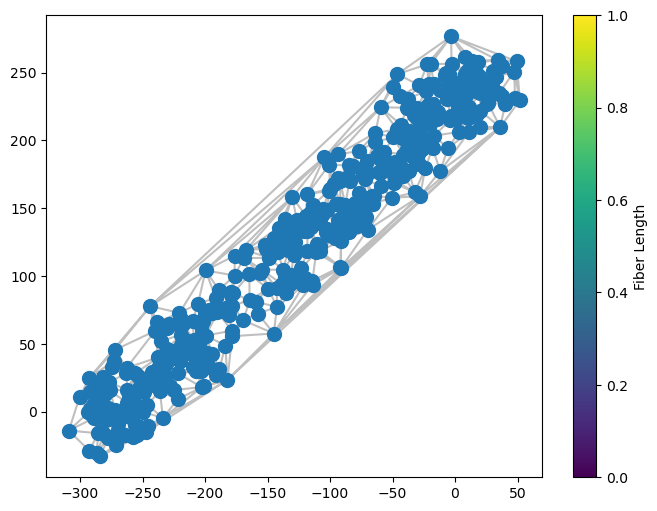

In [8]:
#delaunay triangulation test
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import networkx as nx
from torch_geometric.data import Data

graph_key = 'sim_0_2'  # Replace with the desired key
SPP_data = SPP_dataset[graph_key]

points = SPP_data.x.numpy()  # Convert tensor to numpy array
tri = Delaunay(SPP_data.x.numpy())  # Use fiber_points (SPP_data.x) for Delaunay triangulation
num_points = len(points)

# Step 2: Extract edges from the triangulation
edges = set()
for simplex in tri.simplices:
    # Create edges from the vertices of each triangle
    for i in range(3):
        edges.add((simplex[i], simplex[(i + 1) % 3]))

edges = np.array(list(edges))

# Convert edges to edge index format suitable for PyTorch
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
print("Edge index:", edge_index)
print("Edge index shape:", edge_index.shape)

# Step 3: Create graph from edges using NetworkX
G = nx.Graph()
for edge in edges:
    if edge[0] < num_points and edge[1] < num_points:  # Ensure the nodes are within range
        G.add_edge(edge[0], edge[1])

# Optionally, plot the points and edges (Delaunay triangulation visualization)
plt.figure(figsize=(8, 6))
plt.triplot(SPP_data.x[:, 0], SPP_data.x[:, 1], tri.simplices, color='gray', alpha=0.5)
plt.scatter(SPP_data.x[:, 0], SPP_data.x[:, 1], cmap='viridis', s=100)
plt.colorbar(label="Fiber Length")
plt.show()

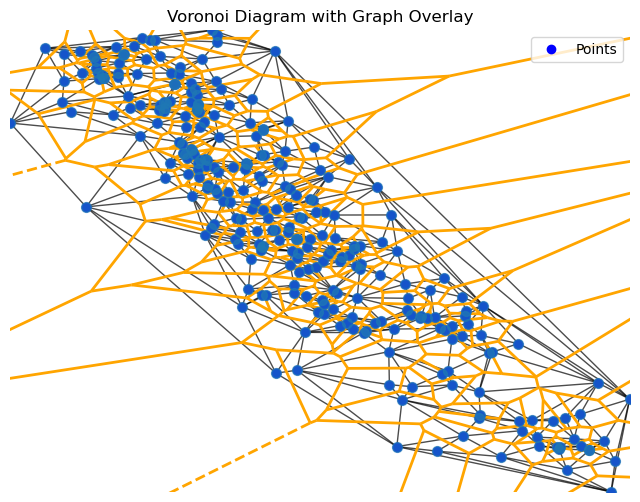

In [21]:
#voronoi tesselation test
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import networkx as nx
from scipy.spatial import distance

def _extract_edges_from_voronoi(vor):
        """
        Extract edges from Voronoi diagram more robustly
        
        Args:
            vor: Voronoi diagram object from scipy.spatial
            
        Returns:
            np.ndarray: Edge list as pairs of point indices
        """
        edges = []
        
        # Use ridge_points directly as they represent pairs of points whose cells are adjacent
        for ridge_points in vor.ridge_points:
            # ridge_points contains indices of input points whose cells are adjacent
            edges.append(ridge_points)

        '''

        if not edges:
            # Fallback method if no valid ridges found
            for i, point1 in enumerate(vor.points[:-1]):
                for j, point2 in enumerate(vor.points[i+1:], i+1):
                    # Add edge if points are close enough (you might want to adjust this threshold)
                    if np.linalg.norm(point1 - point2) < np.mean([
                        np.linalg.norm(vor.points[i+1:] - point1, axis=1).min() 
                        for i in range(len(vor.points)-1)
                    ]):
                        edges.append([i, j])
        '''
        
        return np.array(edges)

def create_voronoi_graph(SPP_data, graph_key):
    points = SPP_data[graph_key].x.numpy()
    vor = Voronoi(points)
    
    # Comprehensive edge extraction
    # Add small random perturbation to prevent colinear points
    #points += np.random.rand(*points.shape) * 1e-10
    
    
    vor = Voronoi(points)
    edges = _extract_edges_from_voronoi(vor)
    
    if len(edges) == 0:
        print(f"Warning: No edges found for graph {graph_key}. Creating minimal connecting edges.")
        # Create minimal connecting edges if no edges found
        edges = np.array([[i, i+1] for i in range(len(points)-1)])
        print(edges)
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    G = nx.from_edgelist(edges)
    
    return {
        'points': points,
        'voronoi': vor,
        'graph': G,
        'edge_index': edge_index
    }

def visualize_voronoi_graph(graph_data):
    """Visualize Voronoi diagram with graph overlay"""
    fig, ax = plt.subplots(figsize=(8, 6))
    
    points = graph_data['points']
    vor = graph_data['voronoi']
    G = graph_data['graph']
    
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='orange', line_width=2)
    
    ax.plot(points[:, 0], points[:, 1], 'o', color='blue', label="Points")
    
    pos = {i: (points[i, 0], points[i, 1]) for i in range(len(points))}
    nx.draw(G, pos, ax=ax, with_labels=False, node_size=50, edge_color="black", alpha=0.7)
    
    ax.set_xlim(points[:, 0].min() - 0.1, points[:, 0].max() + 0.1)
    ax.set_ylim(points[:, 1].min() - 0.1, points[:, 1].max() + 0.1)
    
    ax.set_title("Voronoi Diagram with Graph Overlay")
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage
graph_key = 'sim_0_1'
graph_data = create_voronoi_graph(SPP_dataset, graph_key)
visualize_voronoi_graph(graph_data)

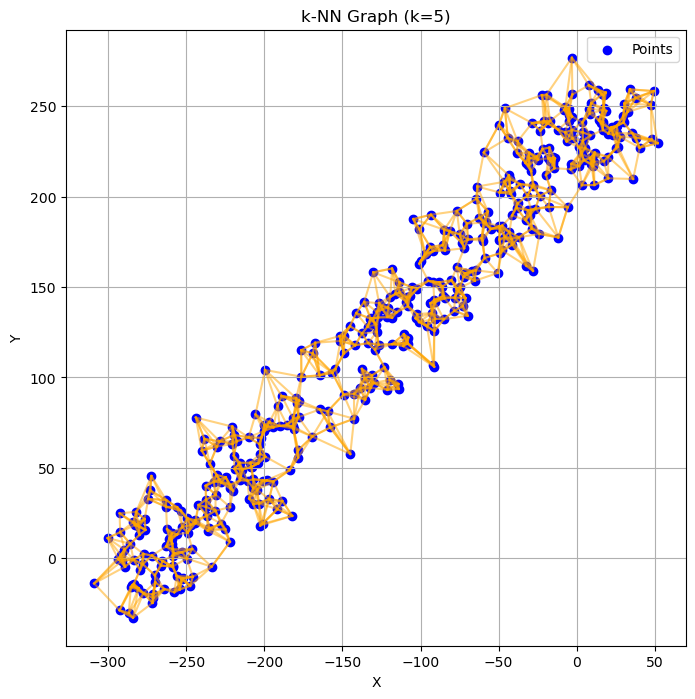

In [10]:
#knn
import torch
from torch_cluster import knn_graph
k = 5
graph_key = 'sim_0_2'  # Replace with the desired key
SPP_data = SPP_dataset[graph_key]

x = SPP_data.x  # Convert tensor to numpy array
num_points = len(x)
batch = torch.zeros(num_points, dtype=torch.long)
edge_index = knn_graph(x, k, batch=batch, loop=False)

def visualize_knn_graph(x, edge_index):
    # Convert tensor to numpy for plotting
    points = x.numpy()
    edges = edge_index.numpy()

    plt.figure(figsize=(8, 8))
    plt.scatter(points[:, 0], points[:, 1], color='blue', label='Points')

    # Plot edges based on k-NN connections
    for i, j in edges.T:
        point_i = points[i]
        point_j = points[j]
        plt.plot([point_i[0], point_j[0]], [point_i[1], point_j[1]], 'orange', alpha=0.5)

    plt.title(f"k-NN Graph (k={k})")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the visualization function
visualize_knn_graph(x, edge_index)

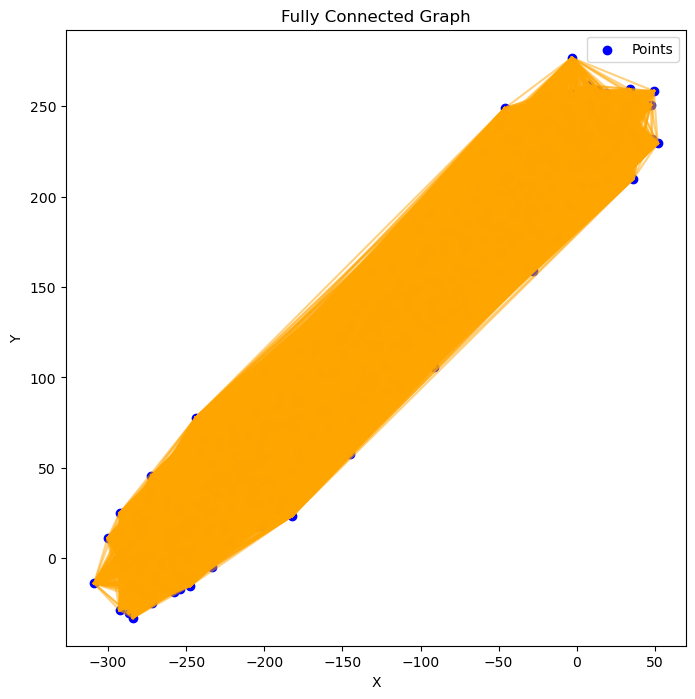

tensor([[  1,   2,   2,  ..., 441, 441, 441],
        [  0,   0,   1,  ..., 438, 439, 440]])


In [11]:
#fully connected graph test; very slow 
import torch
import matplotlib.pyplot as plt
from itertools import combinations

# Define the graph key
graph_key = 'sim_0_2'  # Replace with the desired key
SPP_data = SPP_dataset[graph_key]

# Generate edge indices for a fully connected graph (without itertools)
# We use tril_indices to get all lower triangular indices, excluding the diagonal (i < j)
edges_row, edges_col = torch.tril_indices(num_points, num_points, offset=-1)

# Combine the row and column indices to form the edge_index
edge_index = torch.stack([edges_row, edges_col], dim=0)  # Shape: [2, num_edges]


# Step 2: Visualize the fully connected graph
def visualize_fully_connected_graph(points, edge_index):
    plt.figure(figsize=(8, 8))
    plt.scatter(points[:, 0].numpy(), points[:, 1].numpy(), color='blue', label='Points')

    # Plot each edge in the fully connected graph
    for i, j in edge_index.t():
        point_i = points[i]
        point_j = points[j]
        plt.plot([point_i[0].item(), point_j[0].item()], [point_i[1].item(), point_j[1].item()], color='orange', alpha=0.5)

    plt.title("Fully Connected Graph")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend(loc = 'upper right')
    plt.show()

# Call the visualization function
visualize_fully_connected_graph(SPP_data.x, edge_index)
print(edge_index)


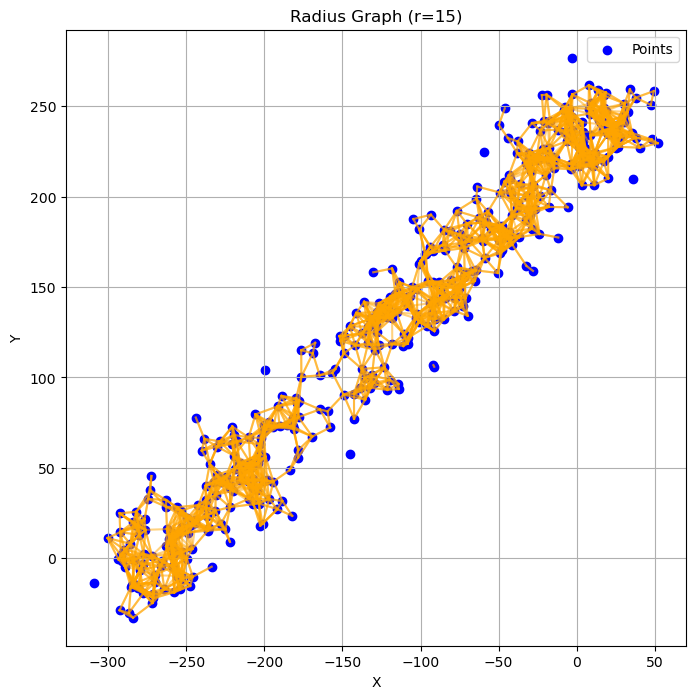

In [12]:
#radius graph
#not working great...
import torch
from torch_cluster import radius_graph
r = 15
graph_key = 'sim_0_2'  # Replace with the desired key
SPP_data = SPP_dataset[graph_key]

x = SPP_data.x  # Convert tensor to numpy array
num_points = len(x)
batch = torch.zeros(num_points, dtype=torch.long)
edge_index = radius_graph(x, r, batch=batch, loop=False, max_num_neighbors=15)

def visualize_radius_graph(x, edge_index):
    # Convert tensor to numpy for plotting
    points = x.numpy()
    edges = edge_index.numpy()

    plt.figure(figsize=(8, 8))
    plt.scatter(points[:, 0], points[:, 1], color='blue', label='Points')

    # Plot edges based on k-NN connections
    for i, j in edges.T:
        point_i = points[i]
        point_j = points[j]
        plt.plot([point_i[0], point_j[0]], [point_i[1], point_j[1]], 'orange', alpha=0.5)

    plt.title(f"Radius Graph (r={r})")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the visualization function
visualize_radius_graph(x, edge_index)

In [13]:
#tests w/ structure of descriptor
specific_line = descriptor.iloc[1]
column_value = descriptor.iloc[0]['sim_idx']
#print(sim_dict['sim_0'])
#print(sim_dict['sim_0']['lengths'])

In [14]:
#delaunay graph dataset class 
import torch
from torch_geometric.data import Data, Dataset
import numpy as np
from scipy.spatial import Delaunay
import networkx as nx
from torch_geometric.utils import to_undirected
import os
from typing import Optional, Callable

class DelaunayGraphDataset(Dataset):
    def __init__(self, 
                 root: str, 
                 SPP_dataset: dict,
                 transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        """
        Custom PyG Dataset for Delaunay triangulation graphs
        
        Args:
            root: Root directory where the dataset should be saved
            SPP_dataset: Dictionary containing the original SPP data
            transform: Optional transform to be applied on each Data object
            pre_transform: Optional transform to be applied on each Data object before saving
        """
        self.SPP_dataset = SPP_dataset
        super().__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        """List of processed file names."""
        return [f'data_{idx}.pt' for idx in range(len(self.SPP_dataset))]

    def download(self):
        pass

    def process(self):
        idx = 0
        for graph_key in self.SPP_dataset:
            # Get data for current graph
            SPP_data = self.SPP_dataset[graph_key]
            
            points = SPP_data.x.numpy()
            tri = Delaunay(points)
            num_points = len(points)

            # Extract edges from triangulation
            edges = set()
            for simplex in tri.simplices:
                for i in range(3):
                    edges.add((simplex[i], simplex[(i + 1) % 3]))

            edges = np.array(list(edges))
            
            # Create edge index tensor
            edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

            # Create PyG Data object
            data = Data(
                x=SPP_data.x,
                edge_index=edge_index,
                y=SPP_data.y if hasattr(SPP_data, 'y') else None,
                #pos=SPP_data.x  # Store original positions
            )

            data.edge_index = to_undirected(data.edge_index)

            if self.pre_transform is not None:
                data = self.pre_transform(data)

            torch.save(data, os.path.join(self.processed_dir, f'data_{idx}.pt'))
            idx += 1

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
        return data

# Usage example:
def create_delaunay_dataset(SPP_dataset, root_dir):
    """
    Create a PyG dataset from SPP data with Delaunay triangulation
    
    Args:
        SPP_dataset: Dictionary containing the original SPP data
        root_dir: Directory to save the processed dataset
    
    Returns:
        DelaunayGraphDataset object
    """
    Delaunay_dataset = DelaunayGraphDataset(
        root=root_dir,
        SPP_dataset=SPP_dataset
    )
    return Delaunay_dataset

# Example usage:
dataset = create_delaunay_dataset(SPP_dataset, r'C:\Users\Arthur Champain\Downloads\Arthur-20241118T122838Z-001\delaunay')

Processing...
Done!


In [24]:
#voronoi graph dataset class test
import torch
from torch_geometric.data import Data, Dataset
from torch_geometric.utils import to_undirected
import numpy as np
from scipy.spatial import Voronoi
import os
from typing import Optional, Callable

class VoronoiGraphDataset(Dataset):
    def __init__(self, 
                 root: str, 
                 SPP_dataset: dict,
                 transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        """
        Custom PyG Dataset for Voronoi tesselation graphs
        
        Args:
            root: Root directory where the dataset should be saved
            SPP_dataset: Dictionary containing the original SPP data
            transform: Optional transform to be applied on each Data object
            pre_transform: Optional transform to be applied on each Data object before saving
        """
        self.SPP_dataset = SPP_dataset
        super().__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        """List of processed file names."""
        return [f'data_{idx}.pt' for idx in range(len(self.SPP_dataset))]

    def download(self):
        pass

    def _extract_edges_from_voronoi(self, vor):
        """
        Extract edges from Voronoi diagram more robustly
        
        Args:
            vor: Voronoi diagram object from scipy.spatial
            
        Returns:
            np.ndarray: Edge list as pairs of point indices
        """
        edges = []
        
        # Use ridge_points directly as they represent pairs of points whose cells are adjacent
        for ridge_points in vor.ridge_points:
            # ridge_points contains indices of input points whose cells are adjacent
            edges.append(ridge_points)
        
        '''
            
        if not edges:
            # Fallback method if no valid ridges found
            for i, point1 in enumerate(vor.points[:-1]):
                for j, point2 in enumerate(vor.points[i+1:], i+1):
                    # Add edge if points are close enough (you might want to adjust this threshold)
                    if np.linalg.norm(point1 - point2) < np.mean([
                        np.linalg.norm(vor.points[i+1:] - point1, axis=1).min() 
                        for i in range(len(vor.points)-1)
                    ]):
                        edges.append([i, j])
        '''
        return np.array(edges)

    def process(self):
        idx = 0
        for graph_key in self.SPP_dataset:
            SPP_data = self.SPP_dataset[graph_key]
            points = SPP_data.x.numpy()
            
            # Add small random perturbation to prevent colinear points
            #points += np.random.rand(*points.shape) * 1e-10
            
            try:
                vor = Voronoi(points)
                edges = self._extract_edges_from_voronoi(vor)
                
                '''
                if len(edges) == 0:
                    print(f"Warning: No edges found for graph {idx}. Creating minimal connecting edges.")
                    # Create minimal connecting edges if no edges found
                    edges = np.array([[i, i+1] for i in range(len(points)-1)])
                '''
                edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
                
                # Create the Data object
                data = Data(
                    x=SPP_data.x,
                    edge_index=edge_index,
                    y=SPP_data.y if hasattr(SPP_data, 'y') else None
                )
                
                # Convert to undirected if there are edges
                if edge_index.shape[1] > 0:
                    data.edge_index = to_undirected(data.edge_index)
                
                torch.save(data, os.path.join(self.processed_dir, f'data_{idx}.pt'))
                
            except Exception as e:
                print(f"Error processing graph {idx}: {str(e)}")
                # Create a minimal valid graph
                edge_index = torch.tensor([[0, 1], [1, 0]], dtype=torch.long).t()
                data = Data(
                    x=SPP_data.x,
                    edge_index=edge_index,
                    y=SPP_data.y if hasattr(SPP_data, 'y') else None
                )
                torch.save(data, os.path.join(self.processed_dir, f'data_{idx}.pt'))
            
            idx += 1

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
        return data

def create_voronoi_dataset(SPP_dataset, root_dir):
    """
    Create a PyG dataset from SPP data with Voronoi tessellation
    
    Args:
        SPP_dataset: Dictionary containing the original SPP data
        root_dir: Directory to save the processed dataset
    
    Returns:
        VoronoiGraphDataset object
    """
    return VoronoiGraphDataset(
        root=root_dir,
        SPP_dataset=SPP_dataset
    )

# Example usage:
dataset = create_voronoi_dataset(SPP_dataset, r'C:\Users\Arthur Champain\Downloads\Arthur-20241118T122838Z-001\voronoi')

Processing...
Done!


In [25]:
#knn graph dataset class test
import torch
from torch_geometric.data import Data, Dataset
import numpy as np
from torch_cluster import knn_graph
import networkx as nx
import os
from typing import Optional, Callable

class knnGraphDataset(Dataset):
    def __init__(self, 
                 root: str, 
                 SPP_dataset: dict,
                 k: int,
                 transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        """
        Custom PyG Dataset for knnn graphs
        
        Args:
            root: Root directory where the dataset should be saved
            SPP_dataset: Dictionary containing the original SPP data
            transform: Optional transform to be applied on each Data object
            pre_transform: Optional transform to be applied on each Data object before saving
        """
        self.SPP_dataset = SPP_dataset
        self.k = k
        super().__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        """List of processed file names."""
        return [f'data_{idx}.pt' for idx in range(len(self.SPP_dataset))]

    def download(self):
        pass

    def process(self):
        idx = 0
        for graph_key in self.SPP_dataset:

            SPP_data = self.SPP_dataset[graph_key]
            
            points = SPP_data.x
            num_points = len(points)

            batch = torch.zeros(num_points, dtype=torch.long)
            edge_index = knn_graph(points, k, batch=batch, loop=False)

            # Create PyG Data object
            data = Data(
                x=SPP_data.x,
                edge_index=edge_index,
                y=SPP_data.y if hasattr(SPP_data, 'y') else None
            )

            data.edge_index = to_undirected(data.edge_index)

            if self.pre_transform is not None:
                data = self.pre_transform(data)

            torch.save(data, os.path.join(self.processed_dir, f'data_{idx}.pt'))
            idx += 1

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
        return data

# Usage example:
def create_knn_dataset(SPP_dataset, root_dir, k):
    """
    Create a PyG dataset from SPP data with knn
    
    Args:
        SPP_dataset: Dictionary containing the original SPP data
        root_dir: Directory to save the processed dataset
    
    Returns:
        knnGraphDataset object
    """
    knn_dataset = knnGraphDataset(
        root=root_dir,
        k=k,
        SPP_dataset=SPP_dataset
    )
    return knn_dataset

# Example usage:
dataset = create_knn_dataset(SPP_dataset, r'C:\Users\Arthur Champain\Downloads\Arthur-20241118T122838Z-001\knn', 7)

Processing...
Done!


In [32]:
#radius graph dataset class test (tout pourri)
import torch
from torch_geometric.data import Data, Dataset
import numpy as np
from torch_cluster import knn_graph
import networkx as nx
import os
from typing import Optional, Callable

class radiusGraphDataset(Dataset):
    def __init__(self, 
                 root: str, 
                 SPP_dataset: dict,
                 r: int,
                 transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        """
        Custom PyG Dataset for radius graphs
        
        Args:
            root: Root directory where the dataset should be saved
            SPP_dataset: Dictionary containing the original SPP data
            transform: Optional transform to be applied on each Data object
            pre_transform: Optional transform to be applied on each Data object before saving
        """
        self.SPP_dataset = SPP_dataset
        self.r = r
        super().__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        """List of processed file names."""
        return [f'data_{idx}.pt' for idx in range(len(self.SPP_dataset))]

    def download(self):
        pass

    def process(self):
        idx = 0
        for graph_key in self.SPP_dataset:

            SPP_data = self.SPP_dataset[graph_key]
            
            points = SPP_data.x
            num_points = len(points)

            batch = torch.zeros(num_points, dtype=torch.long)
            edge_index = radius_graph(points, r, batch=batch, loop=False, max_num_neighbors=15)

            # Create PyG Data object
            data = Data(
                x=SPP_data.x,
                edge_index=edge_index,
                y=SPP_data.y if hasattr(SPP_data, 'y') else None
            )

            data.edge_index = to_undirected(data.edge_index)

            if self.pre_transform is not None:
                data = self.pre_transform(data)

            torch.save(data, os.path.join(self.processed_dir, f'data_{idx}.pt'))
            idx += 1

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
        return data

# Usage example:
def create_radius_dataset(SPP_dataset, root_dir, r):
    """
    Create a PyG dataset from SPP data with radius
    
    Args:
        SPP_dataset: Dictionary containing the original SPP data
        root_dir: Directory to save the processed dataset
    
    Returns:
        radiusGraphDataset object
    """
    radius_dataset = radiusGraphDataset(
        root=root_dir,
        r=r,
        SPP_dataset=SPP_dataset
    )
    return radius_dataset

# Example usage:
dataset = create_radius_dataset(SPP_dataset, r'C:\Users\Arthur Champain\Downloads\Arthur-20241118T122838Z-001\radius', 15)

In [27]:
#fully connected graph dataset class test

import torch
from torch_geometric.data import Data, Dataset
import numpy as np
from torch_cluster import knn_graph
import networkx as nx
import os
from typing import Optional, Callable

class fullGGraphDataset(Dataset):
    def __init__(self, 
                 root: str, 
                 SPP_dataset: dict,
                 transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        """
        Custom PyG Dataset for fully connected graphs
        
        Args:
            root: Root directory where the dataset should be saved
            SPP_dataset: Dictionary containing the original SPP data
            transform: Optional transform to be applied on each Data object
            pre_transform: Optional transform to be applied on each Data object before saving
        """
        self.SPP_dataset = SPP_dataset
        super().__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        """List of processed file names."""
        return [f'data_{idx}.pt' for idx in range(len(self.SPP_dataset))]

    def download(self):
        pass

    def process(self):
        idx = 0
        for graph_key in self.SPP_dataset:

            SPP_data = self.SPP_dataset[graph_key]
            
            points = SPP_data.x
            num_points = len(points)

            # Generate edge indices for a fully connected graph (without itertools)
            # We use tril_indices to get all lower triangular indices, excluding the diagonal (i < j)
            edges_row, edges_col = torch.tril_indices(num_points, num_points, offset=-1)

            # Combine the row and column indices to form the edge_index
            edge_index = torch.stack([edges_row, edges_col], dim=0)
            
            # Create PyG Data object
            data = Data(
                x=SPP_data.x,
                edge_index=edge_index,
                y=SPP_data.y if hasattr(SPP_data, 'y') else None
            )
            
            data.edge_index = to_undirected(data.edge_index)

            if self.pre_transform is not None:
                data = self.pre_transform(data)

            torch.save(data, os.path.join(self.processed_dir, f'data_{idx}.pt'))
            idx += 1

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
        return data

# Usage example:
def create_fullG_dataset(SPP_dataset, root_dir):
    """
    Create a PyG dataset from SPP data with full coinnection
    
    Args:
        SPP_dataset: Dictionary containing the original SPP data
        root_dir: Directory to save the processed dataset
    
    Returns:
        fullGGraphDataset object
    """
    fullG_dataset = fullGGraphDataset(
        root=root_dir,
        SPP_dataset=SPP_dataset
    )
    return fullG_dataset

# Example usage:
dataset = create_fullG_dataset(SPP_dataset, r'C:\Users\Arthur Champain\Downloads\Arthur-20241118T122838Z-001\fullG')

Processing...
Done!


In [33]:
#check structure of dataset
print(dataset)

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
#print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

radiusGraphDataset(382)

Dataset: radiusGraphDataset(382):
Number of graphs: 382
Number of features: 2

Data(x=[404, 2], edge_index=[2, 5136], y=523.5999755859375)
Number of nodes: 404
Number of edges: 5136
Average node degree: 12.71
Has isolated nodes: True
Has self-loops: False
Is undirected: True


C:\Users\Arthur Champain\AppData\Local\Temp\ipykernel_17584\1941663529.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir

In [34]:
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split

# Get the total dataset length
total_length = len(dataset)

# Define the proportions for splits
length_test = total_length // 4  # Test dataset size (25% of total)
length_train = total_length - length_test  # Remaining for training and validation

# Split the dataset into training and test datasets
train_dataset, test_dataset = random_split(dataset, [length_train, length_test])

# Further split the training dataset into training and validation
batch_size = length_train // 10  # Define batch size for training
length_valid = batch_size  # Validation set will be one batch
length_train_final = length_train - length_valid  # Remaining for actual training

train_dataset_final, valid_dataset = random_split(train_dataset, [length_train_final, length_valid])

# Create data loaders
train_loader = DataLoader(train_dataset_final, batch_size=batch_size, shuffle=False)  # Non-shuffled training loader
valid_loader = DataLoader(valid_dataset, batch_size=length_valid, shuffle=False)  # Single validation batch
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Non-shuffled test loader

# Print information about the loaders
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

# Validation loader check
for step, data in enumerate(valid_loader):
    print(f'Validation Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the validation batch: {data.num_graphs}')
    print(data)
    print()


C:\Users\Arthur Champain\AppData\Local\Temp\ipykernel_17584\1941663529.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir

Step 1:
Number of graphs in the current batch: 28
DataBatch(x=[10355, 2], edge_index=[2, 135396], y=[28], batch=[10355], ptr=[29])

Step 2:
Number of graphs in the current batch: 28
DataBatch(x=[10399, 2], edge_index=[2, 131680], y=[28], batch=[10399], ptr=[29])

Step 3:
Number of graphs in the current batch: 28
DataBatch(x=[10043, 2], edge_index=[2, 128718], y=[28], batch=[10043], ptr=[29])

Step 4:
Number of graphs in the current batch: 28
DataBatch(x=[9877, 2], edge_index=[2, 128940], y=[28], batch=[9877], ptr=[29])

Step 5:
Number of graphs in the current batch: 28
DataBatch(x=[9972, 2], edge_index=[2, 127152], y=[28], batch=[9972], ptr=[29])

Step 6:
Number of graphs in the current batch: 28
DataBatch(x=[10874, 2], edge_index=[2, 139238], y=[28], batch=[10874], ptr=[29])

Step 7:
Number of graphs in the current batch: 28
DataBatch(x=[11605, 2], edge_index=[2, 150748], y=[28], batch=[11605], ptr=[29])

Step 8:
Number of graphs in the current batch: 28
DataBatch(x=[9682, 2], edge_in

In [35]:
#model test

from torch.nn import Linear, Sequential, BatchNorm1d, LeakyReLU
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn import GINConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, output=1):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 1)

        #self.conv1 = GCNConv(hidden_channels*3, hidden_channels)
        
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        
        self.lin = Linear(hidden_channels, output)

    def forward(self, x, edge_index, batch):

        x = x.float()
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
    

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        
        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64, output=1)

C:\Users\Arthur Champain\AppData\Local\Temp\ipykernel_17584\1941663529.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir

In [36]:
#model run test
#random rotation of data.x
def random_rotate_2d(points):
    """
    Applies a random 2D rotation to the given points.
    Args:
        points (torch.Tensor): Tensor of shape (n, 2) representing the points.
    Returns:
        torch.Tensor: Rotated points of shape (n, 2).
    """
    random_angle = torch.rand(1) * 2 * torch.pi  # Random angle in [0, 2π) as a Tensor
    rotation_matrix = torch.tensor([
        [torch.cos(random_angle), -torch.sin(random_angle)],
        [torch.sin(random_angle), torch.cos(random_angle)]
    ]).squeeze()  # Remove any extra dimensions
    rotated_points = torch.matmul(points, rotation_matrix.T)  # Rotate the points
    return rotated_points  # Return only the rotated points



model = GCN(hidden_channels=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

def train():
    model.train()
    for data in train_loader:  # Iterate in batches over the training dataset.
        rotated_data = random_rotate_2d(data.x)  # Randomly rotate the input data
        out = model(rotated_data, data.edge_index, data.batch)  # Model output
        out = out.view(-1)  # Flatten to match `data.y` 
        target = data.y.view(-1).float()  # Get the ground-truth labels      
        loss = criterion(out, target) # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(dataset):
    model.eval()
    total_loss = 0
    for data in dataset:  # Iterate in batches over the dataset
        rotated_data = random_rotate_2d(data.x)  # Randomly rotate the input data
        out = model(rotated_data, data.edge_index, data.batch)  # Model output  # Model output
        out = out.view(-1)  # Flatten to match `data.y` 
        target = data.y.view(-1).float()  # Get the ground-truth labels      
        loss = criterion(out, target)  # Compute MSE loss
        total_loss += loss.item()  # Accumulate loss # Accumulate loss 
    return total_loss / len(dataset)  # Derive ratio of correct predictions.

train_losses = []
test_losses = []

#early_stopping = EarlyStopping(patience=20, min_delta=1e-4)

for epoch in range(1, 171):

    train()
    train_loss = test(train_loader)
    train_losses.append(train_loss)

    # Test and record the test loss
    test_loss = test(test_loader)
    test_losses.append(test_loss)
    
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    '''
    # Check early stopping
    if early_stopping.check(test_loss):
        print(f"Early stopping triggered at epoch {epoch}.")
        break
    '''


C:\Users\Arthur Champain\AppData\Local\Temp\ipykernel_17584\1941663529.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir

Epoch: 001, Train Loss: 99075.4187, Test Loss: 99259.2227
Epoch: 002, Train Loss: 92723.3273, Test Loss: 103805.7500
Epoch: 003, Train Loss: 97280.0977, Test Loss: 110866.9629
Epoch: 004, Train Loss: 93544.3672, Test Loss: 98661.3320
Epoch: 005, Train Loss: 94485.5164, Test Loss: 103739.9355
Epoch: 006, Train Loss: 94834.2586, Test Loss: 99362.7148
Epoch: 007, Train Loss: 95056.7203, Test Loss: 98054.3418
Epoch: 008, Train Loss: 92034.5320, Test Loss: 100750.7852
Epoch: 009, Train Loss: 97251.0031, Test Loss: 96993.7734
Epoch: 010, Train Loss: 93016.5852, Test Loss: 97687.0664
Epoch: 011, Train Loss: 95670.4723, Test Loss: 104695.2461
Epoch: 012, Train Loss: 94224.6328, Test Loss: 101014.7441
Epoch: 013, Train Loss: 97538.1203, Test Loss: 99728.5781
Epoch: 014, Train Loss: 93828.5539, Test Loss: 103642.3730
Epoch: 015, Train Loss: 91349.5023, Test Loss: 100838.7148
Epoch: 016, Train Loss: 90551.8297, Test Loss: 97531.5098
Epoch: 017, Train Loss: 99006.1828, Test Loss: 100510.9727
Epoch

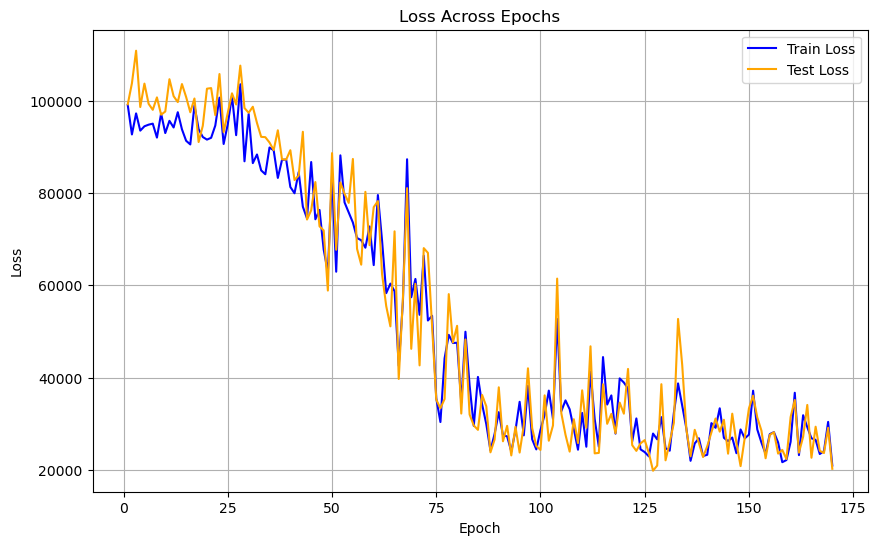

In [38]:
#visualization of model run
import matplotlib.pyplot as plt


# Plot the loss across epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epoch+1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, epoch+1), test_losses, label='Test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Across Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
import torch

def rotate_2d(points, angle):
    """
    Rotates a set of 2D points by the given angle.
    Args:
        points (torch.Tensor): Tensor of shape (n, 2) representing the points.
        angle (float): Rotation angle in radians.
    Returns:
        torch.Tensor: Rotated points of shape (n, 2).
    """
    angle = torch.tensor(angle)  # Convert angle to a tensor
    rotation_matrix = torch.tensor([
        [torch.cos(angle), -torch.sin(angle)],
        [torch.sin(angle), torch.cos(angle)]
    ])
    return torch.matmul(points, rotation_matrix.T)



def evaluate_rotation_invariance(model, data, rotation_fn, angle):
    """
    Evaluates whether the model is rotation-invariant.
    Args:
        model (torch.nn.Module): The trained GCN model.
        data (Data): Graph data containing `x`, `edge_index`, etc.
        rotation_fn (callable): Function to apply rotation to `data.x`.
        angle (float): Rotation angle in radians.
    Returns:
        float: The difference between model outputs on the original and rotated data.
    """
    model.eval()
    
    # Original output
    with torch.no_grad():
        original_out = model(data.x, data.edge_index, data.batch)
    
    # Apply rotation
    rotated_data = data.clone()
    rotated_data.x = rotation_fn(data.x, angle)
    
    # Rotated output
    with torch.no_grad():
        rotated_out = model(rotated_data.x, rotated_data.edge_index, rotated_data.batch)
    
    # Compute the difference
    difference = torch.norm(original_out - rotated_out).item()
    return difference


In [40]:
angles = [0, torch.pi / 4, torch.pi / 2, torch.pi]  # 0°, 45°, 90°, 180°

# Get the second item in the test_loader
test_data = next(iter(valid_loader))
for angle in angles:
    diff = evaluate_rotation_invariance(model, test_data, rotate_2d, angle)
    print(f"Angle: {angle:.2f} rad, Output Difference: {diff:.4f}")


C:\Users\Arthur Champain\AppData\Local\Temp\ipykernel_17584\1941663529.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir

Angle: 0.00 rad, Output Difference: 0.0000
Angle: 0.79 rad, Output Difference: 129.0385
Angle: 1.57 rad, Output Difference: 215.6984
Angle: 3.14 rad, Output Difference: 148.8003
